In [1]:
import numpy as np
import healpy as hp
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from scripts.cosine_smoothed_mask import cosine_smoothed_mask
from scripts.mask_maps import mask_maps


In [2]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)
r=3 #foreground model rank
n_bins=76

In [3]:
dec_noise=np.load('/home/urwa/MASS_Thesis/Thesis/master_noise.npy')
dec_fgds=np.load('/home/urwa/MASS_Thesis/Thesis/master_fgds.npy')
dec_hi=np.load('/home/urwa/MASS_Thesis/Thesis/master_hi.npy')
c_hat=np.load('master_empirical.npy')

In [4]:
ff=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_ff_maps.npy")
sync=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_sync_maps.npy")
hi_maps= np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_hi_maps.npy")*100
noise_maps= np.load("/home/urwa/MASS_Thesis/Thesis/noise_nf.npy")
fgds=sync/1e6 +ff
signal=fgds[:54] + hi_maps
total=signal + noise_maps[:54]
mask = cosine_smoothed_mask(nside)
masked_maps,_ = mask_maps(total, mask, almsize,lmax, nfreqs, npix)

In [6]:
def pca(empirical, r, f):
    """
    Perform PCA on the covariance matrix.
    
    Parameters:
    ----------
    c_hat : np.ndarray
        Covariance matrix of shape (n_bins, n_freq, n_freq).
    
    r : int
        Number of principal components to retain.
    
    Returns:
    -------
    F : np.ndarray
        Matrix of shape (n_freq, r) containing the principal components.
    
    P_b : np.ndarray
        Matrix of shape (n_bins, r, r) containing the eigenvalues and eigenvectors.
    """
    # Perform PCA
    R_global = np.mean(empirical, axis=0)  # c_hat has shape (n_bins, n_freqs, n_freqs)
    #eigen decompositiom
    eigvals, eigvecs = np.linalg.eigh(R_global) #ascending order
    #Take the top r eigenvectors:
    F_i = eigvecs[:, -r:]  # largest eigenvectors
    epsilon=1e-6

    P_b = np.zeros((n_bins, r, r))
    for b in range(n_bins):
        P_b[b] =np.dot( F_i.T , np.dot(empirical[b] , F_i)) #projecting the empirical covariance into the subspace spanned by F.
        P_b[b] = 0.5 * (P_b[b] + P_b[b].T) + epsilon * np.eye(r)
    return eigvals,F_i, P_b*f


In [7]:
factor=370

In [8]:
_,F_pca, P_b_pca = pca(c_hat,r, factor)
# F_pca, P_b_pca = guess_params(nfreqs, n_bins,r)
# e,F_pca, P_b_pca = pca_extended_random_fill(c_hat,5,2)
print(F_pca.shape)
print(P_b_pca.shape)
params_pca = np.concatenate([F_pca.flatten(), P_b_pca.flatten()])
print(params_pca.shape)

(54, 3)
(76, 3, 3)
(846,)


In [9]:
def model_covariance(F, P_b,C_HI, C_noise, n_bins):
    
    # F: (N_channels, r), P_b: (r, r), C_HI & C_noise: (N_channels, N_channels)
    C_b= np.zeros((n_bins, nfreqs, nfreqs))
    for b in range(n_bins):
        C_b[b,:,:]= C_HI[b,:,:]+C_noise[b,:,:] + np.dot(F,np.dot(P_b[b,:,:], F.T))
    return C_b

In [10]:
c_model= model_covariance(F_pca, P_b_pca,dec_hi,dec_noise, n_bins)

In [11]:
def smica(params, hi,noise,empirical,  n_bins, nfreqs, r):
    
    # Reshape the flattened params back into F_init and P_b_init
    
    F_i = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((n_bins,r,r))
    
    
    """# === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])

        F[:, i] /= norm  # normalize column
        for b in range(n_bins):
            P_b[b, i, :] *= norm
            P_b[b, :, i] *= norm  # symmetric scaling"""
    
    
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
                
    # === Compute the cost function ===            
    cost=0
    # model=np.zeros((n_bins, nfreqs, nfreqs))
    # model_inv=np.zeros((n_bins, nfreqs, nfreqs))
    
    # term=np.zeros(n_bins)
    for b in range(n_bins):
        model=  hi[b]+noise[b] + np.dot(F_i, np.dot(P_b[b], F_i.T))
        model_inv= np.linalg.inv(model)
        
        sign, logdet= np.linalg.slogdet(np.dot(empirical[b],model_inv))
        trace=np.trace(np.dot(empirical[b] , model_inv))
        
        term = -logdet + trace-nfreqs
        cost += term
        
    return cost

In [12]:
def jacobian_2(params, hi,noise,  empirical, n_bins, nfreqs, r):
    
    delta_ell=10
    # Reshape the flattened params back into F_init and P_b_init
    F = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((n_bins,r,r))
    
    """# === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])
        
        F[:, i] /= norm  # normalize column
        for b in range(n_bins):
            # Scale row i and column i of P_b[b] accordingly
            P_b[b, i, :] *= norm
            P_b[b, :, i] *= norm """
            
    # Compute norms of each column of F
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
    
    grad_P=np.zeros_like(P_b) # Derivative wrt P_b
    grad_F=np.zeros_like(F) # Derivative wrt F
    
    for b in range(n_bins):
        
        R= hi[b]+noise[b]+np.dot(F, np.dot(P_b[b], F.T)) # model covariance depending on only unknown parameters
        """try:
            R_inv = np.linalg.inv(R)
        except np.linalg.LinAlgError:
            # Optional: add small regularization to make model invertible
            R += 1e-6 * np.identity(nfreqs)
            R_inv = np.linalg.inv(R)"""
        R_inv= np.linalg.inv(R)
        
        Delta= R_inv - np.dot(R_inv,np.dot(empirical[b], R_inv)) #nf x nf

        # ∂φ/∂P_q 
        grad_P[b,:,:]= np.dot(F.T, np.dot(Delta, F)) # (r,r)
        # ∂φ/∂F
        grad_F += 2*np.dot(Delta, np.dot(F, P_b[b])) # (nf,r)
        
    # Flatten the gradients
    grad_P_flat = grad_P.flatten()
    grad_F_flat = grad_F.flatten()
    # print(grad_F_flat.shape)
    # print(grad_P_flat.shape)
    grad_total= np.concatenate([grad_F_flat.flatten(), grad_P_flat.flatten()])
    return grad_total

In [13]:
res = optimize.minimize(
    smica,
    x0=params_pca,
    args=(dec_hi, dec_noise, c_hat, n_bins, nfreqs,r),
    method='trust-constr',
    # constraints=constraint,
    jac=jacobian_2,
    options={'disp': True, 'maxiter':3000, 'gtol':1e-1, 'xtol':1e-10,'barrier_tol': 1e-6, 'verbose': 2}
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +1.1419e+03 | 1.00e+00 | 1.08e+02 | 0.00e+00 |
|   2   |   2   |   1   | +1.1419e+03 | 1.00e-01 | 1.08e+02 | 0.00e+00 |
|   3   |   3   |   3   | +1.1394e+03 | 1.00e-01 | 3.17e+02 | 0.00e+00 |
|   4   |   4   |   6   | +1.1374e+03 | 1.00e-01 | 1.99e+02 | 0.00e+00 |
|   5   |   5   |  10   | +1.1225e+03 | 4.59e-01 | 1.07e+03 | 0.00e+00 |
|   6   |   6   |  15   | +1.0977e+03 | 1.08e+00 | 2.47e+03 | 0.00e+00 |
|   7   |   7   |  21   | +1.0601e+03 | 1.64e+00 | 3.36e+03 | 0.00e+00 |
|   8   |   8   |  27   | +9.9473e+02 | 3.59e+00 | 4.22e+03 | 0.00e+00 |
|   9   |   9   |  34   | +8.0400e+02 | 3.59e+00 | 4.05e+03 | 0.00e+00 |
|  10   |  10   |  41   | +8.0400e+02 | 1.79e+00 | 4.05e+03 | 0.00e+00 |
|  11   |  11   |  47   | +8.0400e+02 | 4.64e-01 | 4.05e+03 | 0.00e+00 |
|  12   |  12   |  53   | +8.0400e+02 | 1.19e-01 | 

In [14]:
from pprint import pprint
pprint(res)

          message: `gtol` termination condition is satisfied.
          success: True
           status: 1
              fun: 16.337444053362667
                x: [ 1.267e-02  2.824e-02 ...  6.473e-05  9.329e-03]
              nit: 1694
             nfev: 1694
             njev: 1694
             nhev: 0
         cg_niter: 328545
     cg_stop_cond: 4
             grad: [-1.628e-03  1.366e-03 ...  4.211e-03  1.492e-03]
  lagrangian_grad: [-1.628e-03  1.366e-03 ...  4.211e-03  1.492e-03]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 0.09834224634038799
 constr_violation: 0
   execution_time: 91.09600639343262
        tr_radius: 0.2677637229494102
   constr_penalty: 1.0
            niter: 1694


In [15]:
result=res.x
print(result.shape)
P_b_out = result[nfreqs*r:].reshape((n_bins,r,r))
F_out = result[:nfreqs*r].reshape((nfreqs, r))
print(P_b_out.shape)
print(F_out.shape)

C_result=np.zeros_like(c_hat)
for b in range(n_bins):
    
    C_result[b]=np.dot(F_out, np.dot(P_b_out[b], F_out.T))


(846,)
(76, 3, 3)
(54, 3)


In [16]:
b = nmt.NmtBin.from_lmax_linear(lmax, 10)
leff = b.get_effective_ells()
f=10

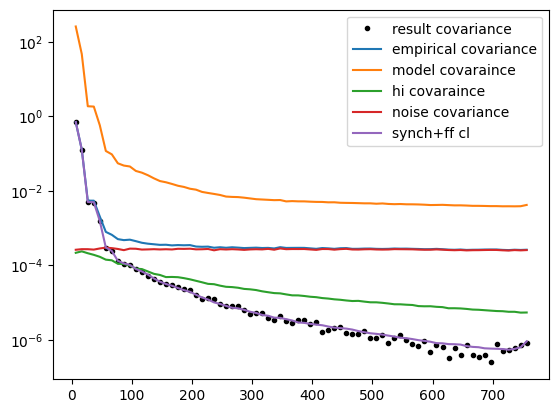

In [37]:
plt.plot(leff,C_result[:,f,f],'k.', label="result covariance")
plt.plot(leff,c_hat[:,f,f], label="empirical covariance")
plt.plot(leff,c_model[:,f,f], label="model covaraince")
plt.plot(leff, dec_hi[:,f,f], label="hi covaraince")
plt.plot(leff,dec_noise[:,f,f], label="noise covariance")
plt.plot(leff, dec_fgds[:,f,f], label="synch+ff cl")
plt.yscale('log')
plt.legend()

In [18]:
def reconstruct_maps_alms_no_whitening(empirical_maps, noise, hi, F, P, nside, ell_bins):
    """
    Reconstruct component maps using Wiener filtering in harmonic space (no whitening).

    Parameters:
    -----------
    empirical_maps : (n_bins, n_freqs, n_freqs)
    noise : (n_bins, n_freqs, n_freqs)
    hi : (n_bins, n_freqs, n_freqs)
    F : (n_freqs, r)
    P : (n_bins, r, r)
    maps : (n_freqs, npix)
    nside : int
    ell_bins : list of tuples
        Each tuple (ell_min, ell_max) defines a multipole bin

    Returns:
    --------
    reconstructed_maps : (r, npix)
    """
    nfreqs = empirical_maps.shape[0]
    r = F.shape[1]
    lmax = 3 * nside - 1
    alm_size = hp.Alm.getsize(lmax)
    
    empirical_alms=np.zeros((nfreqs, alm_size), dtype=complex)
    
    # Convert maps to alms
    for i in range(nfreqs):
        empirical_alms[i,:] =hp.map2alm(empirical_maps[i], lmax=lmax) # shape: (nfreqs, alm_size)

    reconstructed_alms = np.zeros((r, alm_size), dtype=complex)

    for b in range(ell_bins):
        print ("applying filter %d" % b)
        N = noise[b] + hi[b]  # Total noise+foregrounds
        S = F @ P[b] @ F.T    # Signal

        # Compute Wiener filter
        W = P[b] @ F.T @ np.linalg.inv(S + N)  # shape (r, nfreqs)

        # Apply Wiener filter to each (l, m) in the bin
        for l in range(lmax + 1):
            
            for m in range(l + 1):
                idx = hp.Alm.getidx(lmax, l, m)

                a_lm = empirical_alms[:, idx]  # shape: (nfreqs,)

                # Apply Wiener filter
                s_lm = W @ a_lm  # shape: (r,)

                # Store in reconstructed alms
                reconstructed_alms[:, idx] = s_lm
                
    reconstructed_maps=np.zeros((r, hp.nside2npix(nside)), dtype=float)
    # Convert alms back to maps
    for x in range(r):
        print ("reconstructing maps %d" % r)
        reconstructed_maps[x,:] = hp.alm2map(reconstructed_alms[x], nside=nside)
    
    return reconstructed_maps


In [19]:
def reconstruct_maps_alms_whitening(empirical_maps, noise, hi, F, P, nside, ell_bins):
    """
    Reconstruct component maps using Wiener filtering in harmonic space (no whitening).

    Parameters:
    -----------
    empirical_maps : (n_bins, n_freqs, n_freqs)
    noise : (n_bins, n_freqs, n_freqs)
    hi : (n_bins, n_freqs, n_freqs)
    F : (n_freqs, r)
    P : (n_bins, r, r)
    maps : (n_freqs, npix)
    nside : int
    ell_bins : list of tuples
        Each tuple (ell_min, ell_max) defines a multipole bin

    Returns:
    --------
    reconstructed_maps : (r, npix)
    """
    nfreqs = empirical_maps.shape[0]
    r = F.shape[1]
    lmax = 3 * nside - 1
    alm_size = hp.Alm.getsize(lmax)

    reconstructed_alms = np.zeros((r, alm_size), dtype=complex)

    for b in range(ell_bins):
        
        # Whitening transform
        eigvals, eigvecs = np.linalg.eigh(noise[b])
        D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals))
        noise_inv_sqrt = eigvecs @ D_inv_sqrt @ eigvecs.T

        whiten_F = noise_inv_sqrt @ F
        whiten_data = noise_inv_sqrt @ empirical_maps  # shape: (nfreqs, npix)
        
        N = noise[b] + hi[b]  # Total noise+foregrounds
        S = whiten_F @ P[b] @ whiten_F.T    # Signal

        # Compute Wiener filter
        W = P[b] @ whiten_F.T @ np.linalg.inv(S + N)  # shape (r, nfreqs)
        
    empirical_alms=np.zeros((nfreqs, alm_size), dtype=complex)
    # Convert maps to alms
    for i in range(nfreqs):
        empirical_alms[i,:] =hp.map2alm(whiten_data[i], lmax=lmax) # shape: (nfreqs, alm_size)

    # Apply Wiener filter to each (l, m) in the bin
    for l in range(lmax + 1):
        print ("applying filter %d" % l)
        for m in range(l + 1):
            idx = hp.Alm.getidx(lmax, l, m)

            a_lm = empirical_alms[:, idx]  # shape: (nfreqs,)

            # Apply Wiener filter
            s_lm = W @ a_lm  # shape: (r,)

            # Store in reconstructed alms
            reconstructed_alms[:, idx] = s_lm
            
            
    reconstructed_maps=np.zeros((r, hp.nside2npix(nside)), dtype=float)
    # Convert alms back to maps
    for x in range(r):
        print ("reconstructing maps %d" % r)
        reconstructed_maps[x,:] = hp.alm2map(reconstructed_alms[x], nside=nside)
    
    return reconstructed_maps


In [20]:
s=  reconstruct_maps_alms_no_whitening(masked_maps, dec_noise, dec_hi, F_out, P_b_out, nside, n_bins)

applying filter 0
applying filter 1
applying filter 2
applying filter 3
applying filter 4
applying filter 5
applying filter 6
applying filter 7
applying filter 8
applying filter 9
applying filter 10
applying filter 11
applying filter 12
applying filter 13
applying filter 14
applying filter 15
applying filter 16
applying filter 17
applying filter 18
applying filter 19
applying filter 20
applying filter 21
applying filter 22
applying filter 23
applying filter 24
applying filter 25
applying filter 26
applying filter 27
applying filter 28
applying filter 29
applying filter 30
applying filter 31
applying filter 32
applying filter 33
applying filter 34
applying filter 35
applying filter 36
applying filter 37
applying filter 38
applying filter 39
applying filter 40
applying filter 41
applying filter 42
applying filter 43
applying filter 44
applying filter 45
applying filter 46
applying filter 47
applying filter 48
applying filter 49
applying filter 50
applying filter 51
applying filter 52
app

In [21]:
s_white=  reconstruct_maps_alms_whitening(masked_maps, dec_noise, dec_hi, F_out, P_b_out, nside, n_bins)

applying filter 0
applying filter 1
applying filter 2
applying filter 3
applying filter 4
applying filter 5
applying filter 6
applying filter 7
applying filter 8
applying filter 9
applying filter 10
applying filter 11
applying filter 12
applying filter 13
applying filter 14
applying filter 15
applying filter 16
applying filter 17
applying filter 18
applying filter 19
applying filter 20
applying filter 21
applying filter 22
applying filter 23
applying filter 24
applying filter 25
applying filter 26
applying filter 27
applying filter 28
applying filter 29
applying filter 30
applying filter 31
applying filter 32
applying filter 33
applying filter 34
applying filter 35
applying filter 36
applying filter 37
applying filter 38
applying filter 39
applying filter 40
applying filter 41
applying filter 42
applying filter 43
applying filter 44
applying filter 45
applying filter 46
applying filter 47
applying filter 48
applying filter 49
applying filter 50
applying filter 51
applying filter 52
app

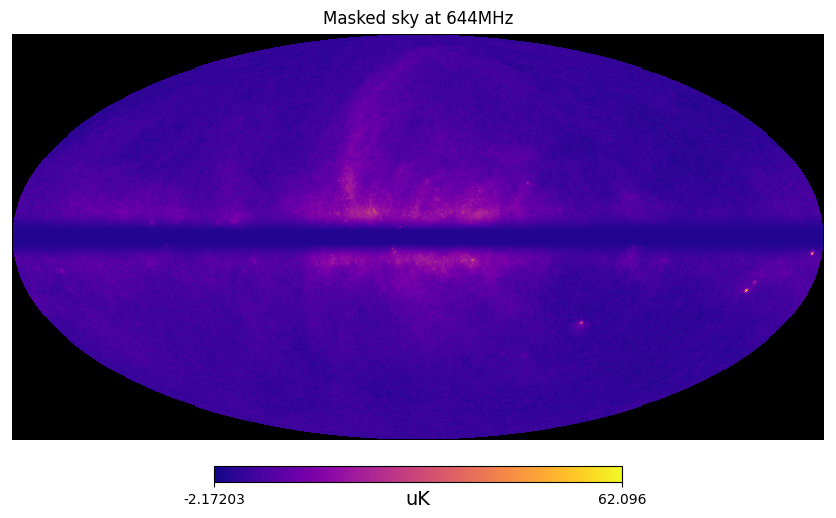

In [22]:
hp.mollview(masked_maps[10], title='Masked sky at 644MHz', unit='uK', bgcolor='black', cmap='plasma')
# plt.style.use('dark_background')

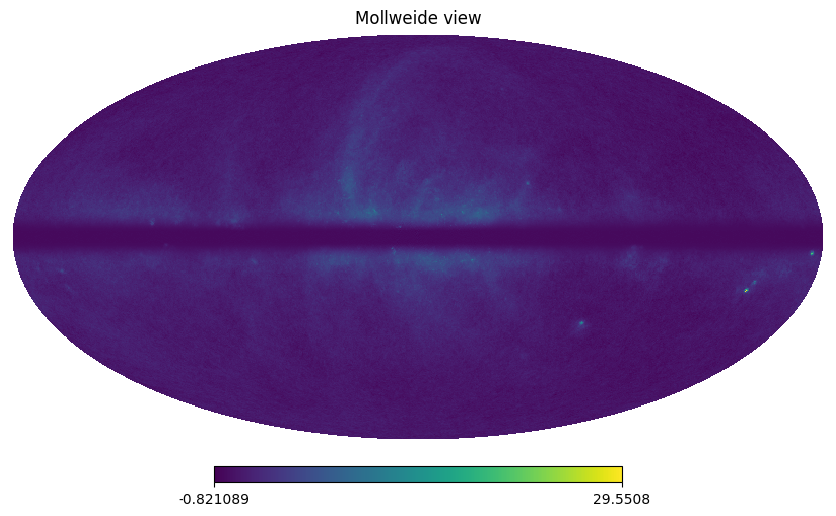

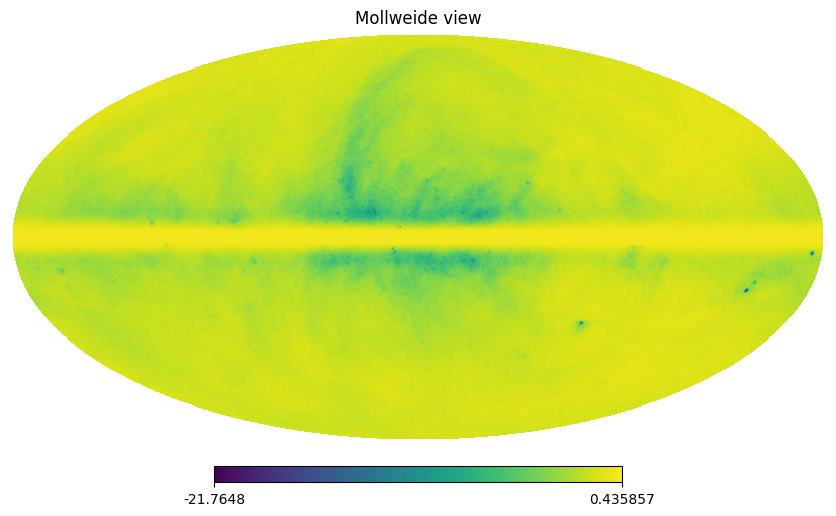

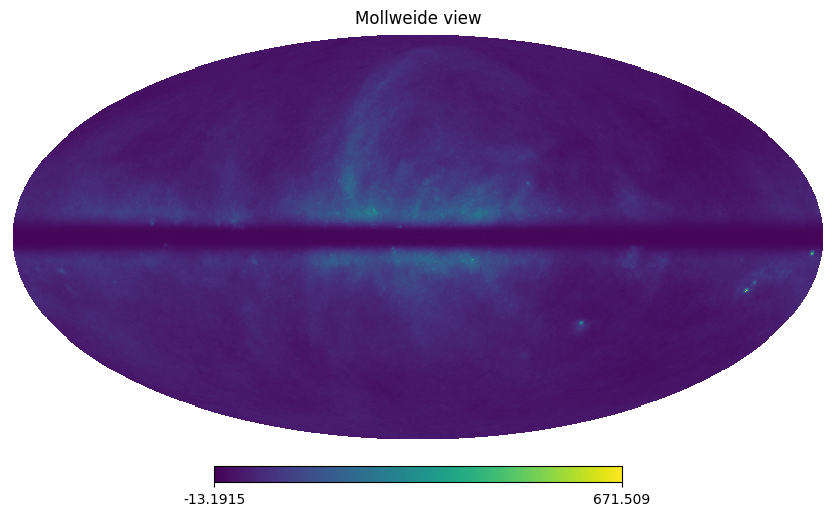

In [23]:
hp.mollview(s[0])
hp.mollview(s[1])
hp.mollview(s[2])

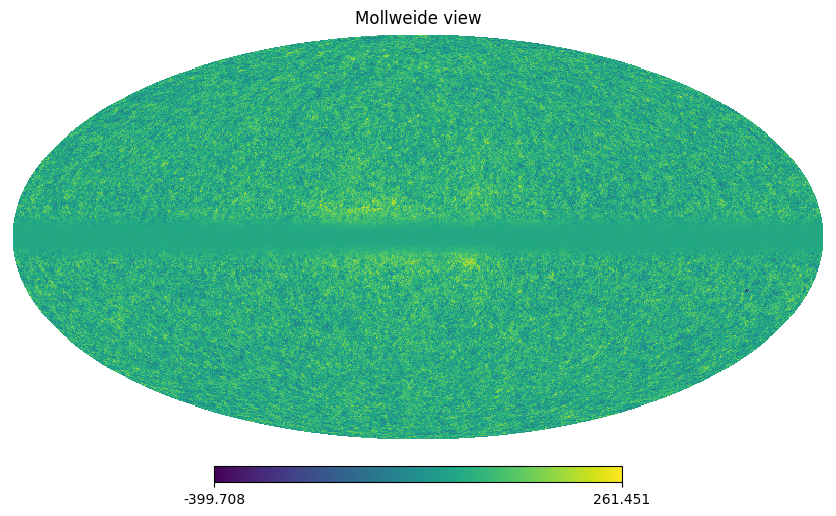

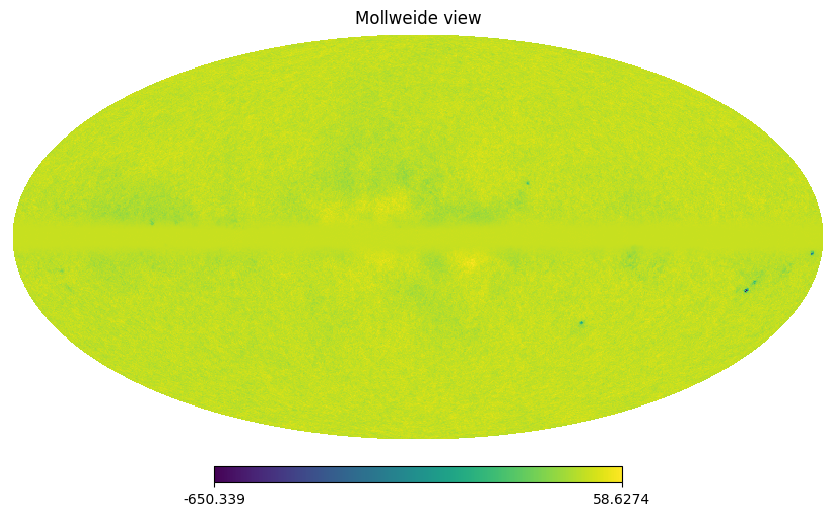

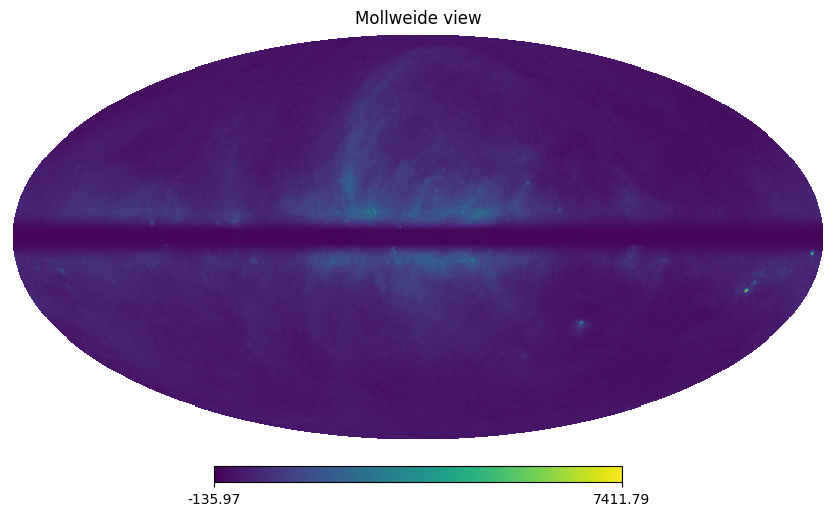

In [24]:
hp.mollview(s_white[0])
hp.mollview(s_white[1])
hp.mollview(s_white[2])

In [25]:
def recovered_maps(comp_maps, F, r):
    """
    Reconstruct the original maps in frequency space from the component maps.

    Parameters:
    -----------
    s : (r, npix)
        Component maps.
    F : (nfreqs, r)
        Mixing matrix.
    r : int
        Number of components.

    Returns:
    --------
    recovered_maps : (nfreqs, npix)
        Reconstructed maps in the original frequency space.
    """
    for i in range (r):
        maps= np.dot(F, comp_maps)  # shape: (nfreqs, npix)
    return   maps

In [26]:
recovered_fgds = recovered_maps(s, F_out, r)

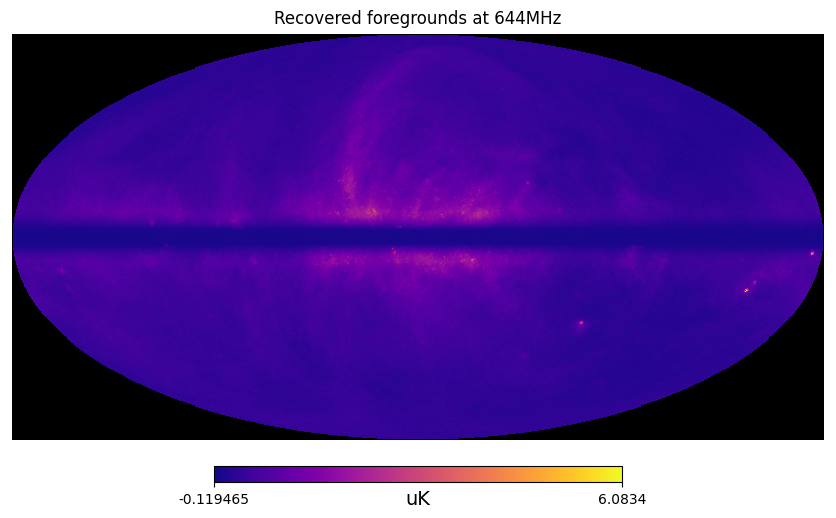

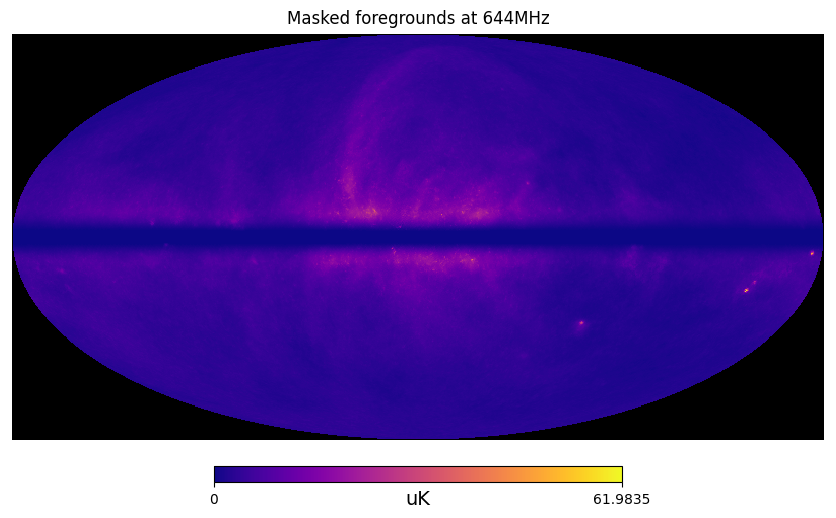

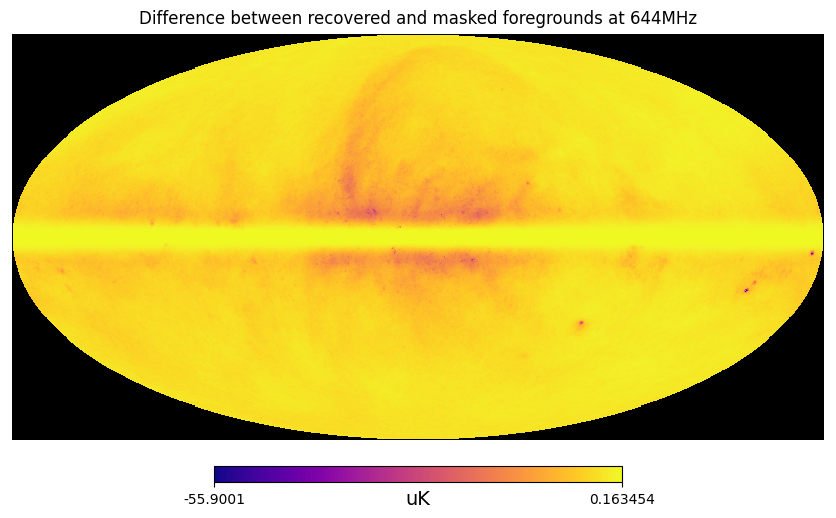

In [61]:
hp.mollview(recovered_fgds[10], bgcolor='black', title='Recovered foregrounds at 644MHz', unit='uK', cmap='plasma')
hp.mollview(mask*fgds[10], bgcolor='black', title='Masked foregrounds at 644MHz', unit='uK', cmap='plasma')
hp.mollview(recovered_fgds[10]-mask*fgds[10], bgcolor='black', title='Difference between recovered and masked foregrounds at 644MHz', unit='uK', cmap='plasma')

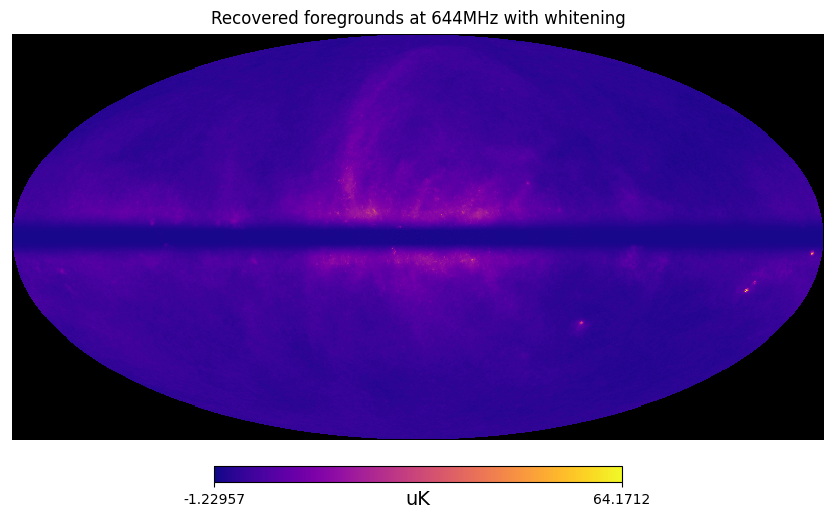

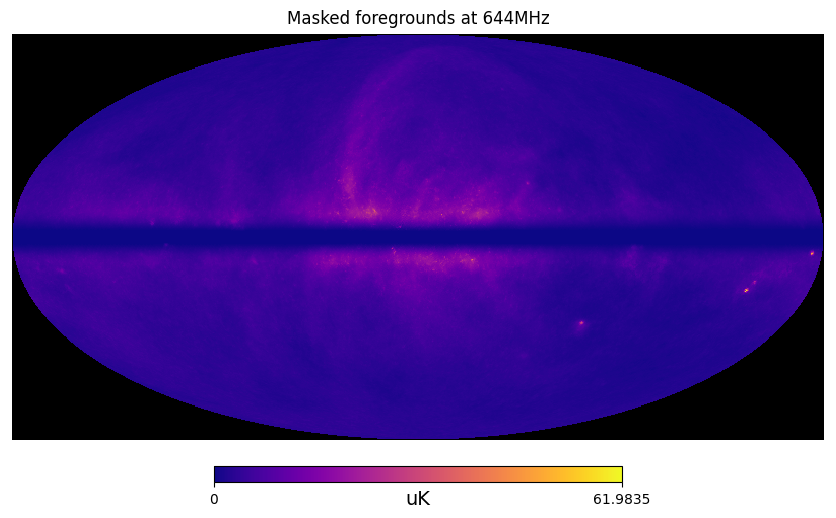

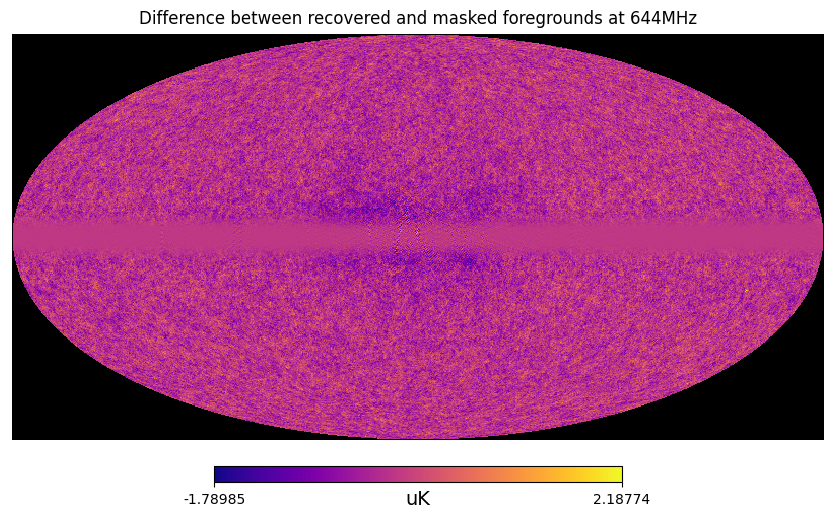

In [28]:
recovered_fgds_white = recovered_maps(s_white, F_out, r)
hp.mollview(recovered_fgds_white[10], bgcolor='black', title='Recovered foregrounds at 644MHz with whitening', unit='uK', cmap='plasma')
hp.mollview(mask*fgds[10], bgcolor='black', title='Masked foregrounds at 644MHz', unit='uK', cmap='plasma')
hp.mollview(recovered_fgds_white[10]-mask*fgds[10], bgcolor='black', title='Difference between recovered and masked foregrounds at 644MHz', unit='uK', cmap='plasma')

In [52]:
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance
cl_fgds= compute_covariance(mask*fgds, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [62]:
def compute_decoupled_cl( maps: np.ndarray, masks:np.ndarray, l_max:int, n_freq:int)-> np.ndarray:
    """
    Compute the power spectra using NaMaster for a set of frequency maps.

    Parameters:
    - maps: numpy array of shape (n_freqs, n_maps) containing the frequency maps
    - masks: mask to apply to the maps
    - X: flag to indicate if the input maps are masked
    - nsides: resolution parameter for the maps
    - l_max: maximum multipole for the power spectra
    - n_freq: number of frequency channels

    Returns:
    - p_cl: raw power spectrum (coupled)
    - matrix: mode coupling matrix
    - cldec: decoupled power spectrum
    """

    cldec = np.zeros((l_max//10, n_freq, n_freq))
    # Define a NaMaster binning scheme (no binning)
    b = nmt.NmtBin.from_lmax_linear(l_max, 10)
    leff = b.get_effective_ells()

    # Loop over all pairs of frequency maps (cross-power spectra)
    for i in range(n_freq):
        print ("processing map %d" % i)
        for j in range(i, n_freq):  # Compute only upper triangle (symmetric matrix)
            
            # Define the masked fields for the two maps
            f_i = nmt.NmtField(masks, [maps[i, :]], lmax=l_max) 
            f_j = nmt.NmtField( masks, [maps[j, :]], lmax=l_max) 
            
            cldec[:,i,j]=nmt.compute_full_master(f_i, f_j, b)

            if i != j:
                cldec[:, j, i] = cldec[:, i, j]
    
    return leff,cldec

In [ ]:
# _,cl=compute_decoupled_cl(recovered_fgds, mask, lmax, nfreqs)

processing map 0


KeyboardInterrupt: 

In [ ]:
# ell, cl_new=cl

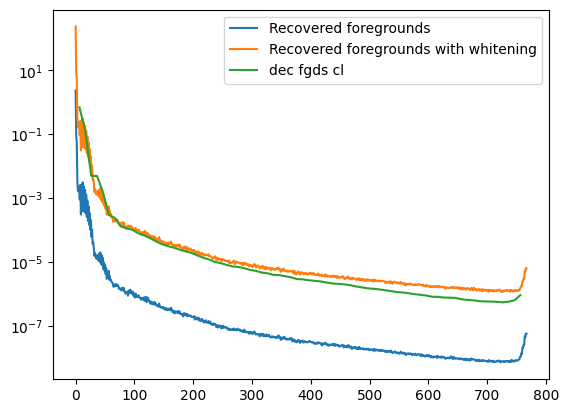

In [74]:
cl=hp.anafast(recovered_fgds[10])
cl_w=hp.anafast(recovered_fgds_white[10])
plt.plot(cl, label='Recovered foregrounds')
plt.plot(cl_w, label='Recovered foregrounds with whitening')
# plt.plot(cl_fgds[:,10,10], label='fgds cl')
plt.plot(leff,dec_fgds[:,10,10], label='dec fgds cl')
plt.yscale('log')
plt.legend()

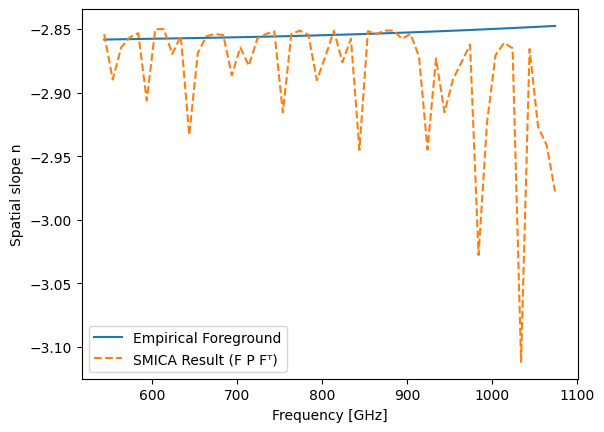

In [32]:
from scipy.stats import linregress

logs = np.log(leff)
powers_fg = []
powers_model = []
intercept_fg = []
intercept_model = []

for i in range(nfreqs):
    y_fg = np.log(dec_fgds[:,i,i])
    y_model = np.log(np.abs(C_result[:,i,i]))

    slope_fg,int_fg,*_ = linregress(logs, y_fg)
    slope_model,int_model,*_ = linregress(logs, y_model)

    powers_fg.append(slope_fg)
    powers_model.append(slope_model)
    
    intercept_fg.append(int_fg)
    intercept_model.append(int_model)
plt.plot(freqs[:-1],powers_fg, label='Empirical Foreground')
plt.plot(freqs[:-1],powers_model, '--', label='SMICA Result (F P Fᵀ)')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Spatial slope n')
plt.legend()


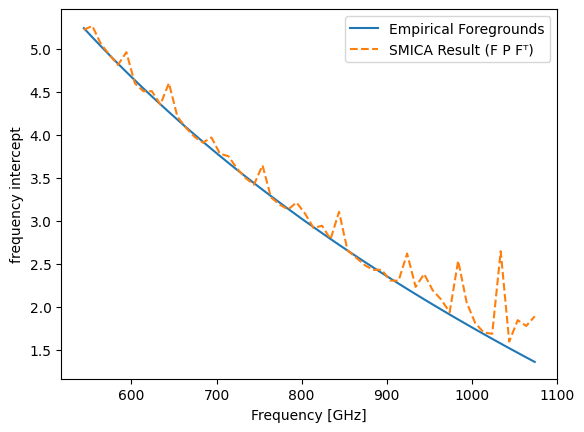

In [33]:
plt.plot(freqs[:-1],intercept_fg, label='Empirical Foregrounds')
plt.plot(freqs[:-1],intercept_model, '--', label='SMICA Result (F P Fᵀ)')
plt.xlabel('Frequency [GHz]')
plt.ylabel('frequency intercept')
plt.legend()